# 1. Time Series Analysis

## Download historical daily stock prices using yfinance.

In [1]:
# Install yfinance if not already installed
!pip install yfinance --quiet

# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better readability
pd.set_option('display.max_columns', None)

# Download GOOGL stock data for the last 5 years
df = yf.download('GOOGL', start='2019-07-01', end='2024-07-01')

# Display the first few rows
df.head()


/tmp/ipython-input-1-522700687.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('GOOGL', start='2019-07-01', end='2024-07-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2019-07-01,54.672115,55.099055,54.440006,54.723803,29196000
2019-07-02,55.298359,55.312772,54.655713,54.912175,20630000
2019-07-03,55.814762,56.063272,55.410187,55.591598,20154000
2019-07-05,56.295876,56.394284,55.541898,55.634839,29794000
2019-07-08,55.506607,56.024501,55.256607,55.957899,29888000


## Visualize the Close price over time.

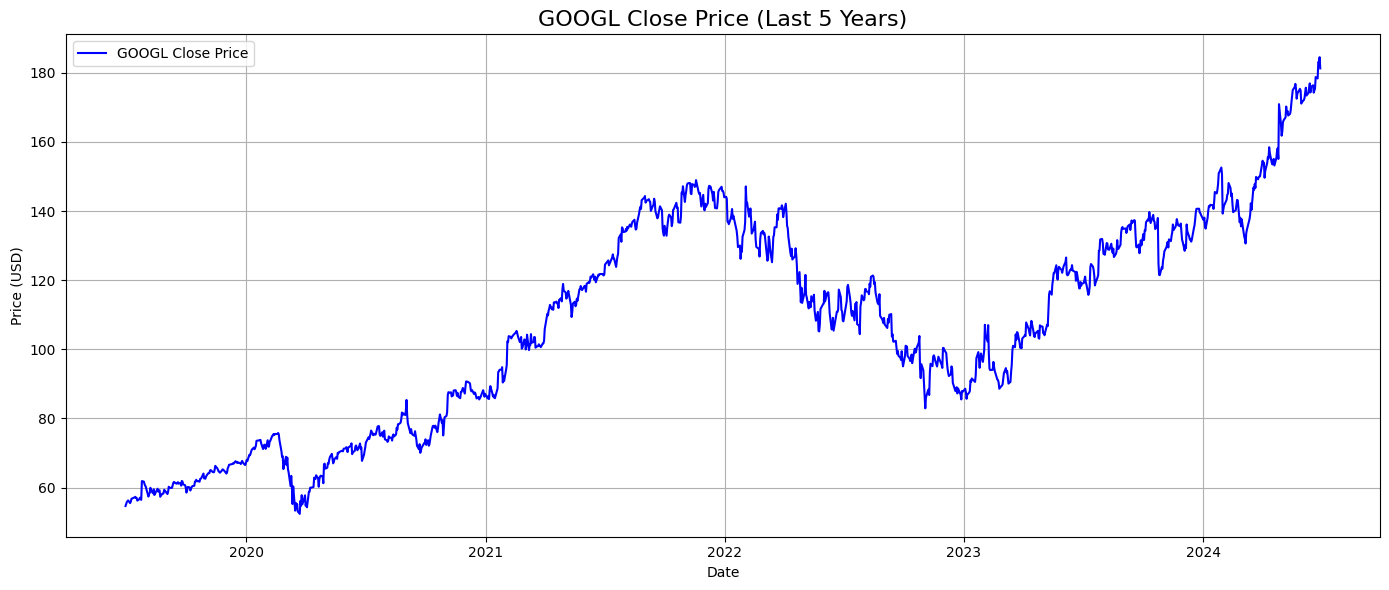

In [2]:
# Plotting the Close price over time
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='GOOGL Close Price', color='blue')
plt.title('GOOGL Close Price (Last 5 Years)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Create and interpret:
* Rolling moving averages (7-day, 30-day)
* Seasonal decomposition of the series (using seasonal_decompose)
* Plot ACF/PACF to understand lags and correlations.

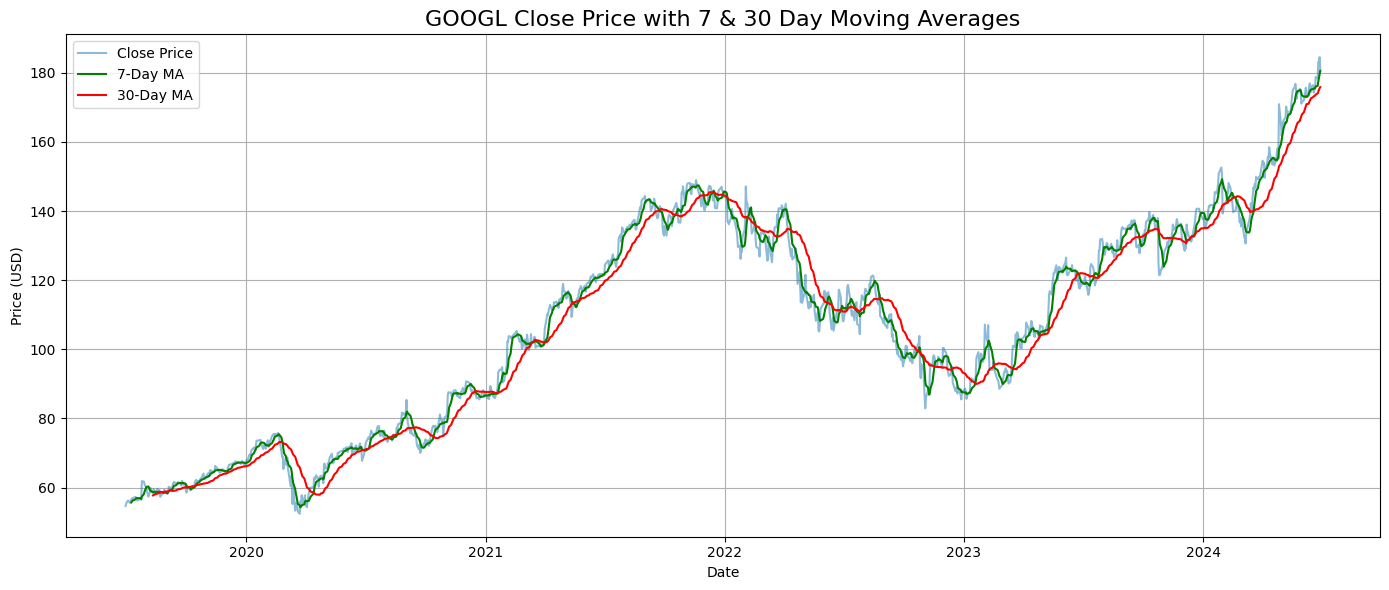

In [3]:
# Calculate moving averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()

# Plot original Close price and moving averages
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA_7'], label='7-Day MA', color='green')
plt.plot(df['MA_30'], label='30-Day MA', color='red')
plt.title('GOOGL Close Price with 7 & 30 Day Moving Averages', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


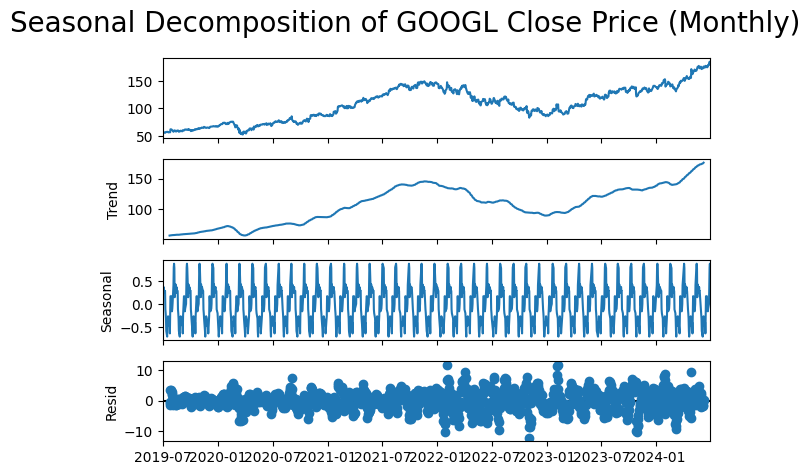

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Drop NA values to avoid issues in decomposition
df_clean = df[['Close']].dropna()

# Apply seasonal decomposition (assumes additive model) For Monthly
decomposition = seasonal_decompose(df_clean['Close'], model='additive', period=30)

# Plot the decomposed components

decomposition.plot()
plt.suptitle('Seasonal Decomposition of GOOGL Close Price (Monthly)', fontsize=20)
plt.tight_layout()
plt.show()


Observed (top plot)
This is the original monthly average Close price for GOOGL.

Trend (2nd plot)

Shows the overall upward movement in GOOGL stock.

There’s a dip in 2022 and recovery after that.

Seasonal (3rd plot)

Shows repeating yearly patterns.

Example: some months regularly go slightly up or down each year.

Residual (bottom plot)

This is the random noise left after removing trend + seasonality.

Large spikes = unusual events or volatility in the market.

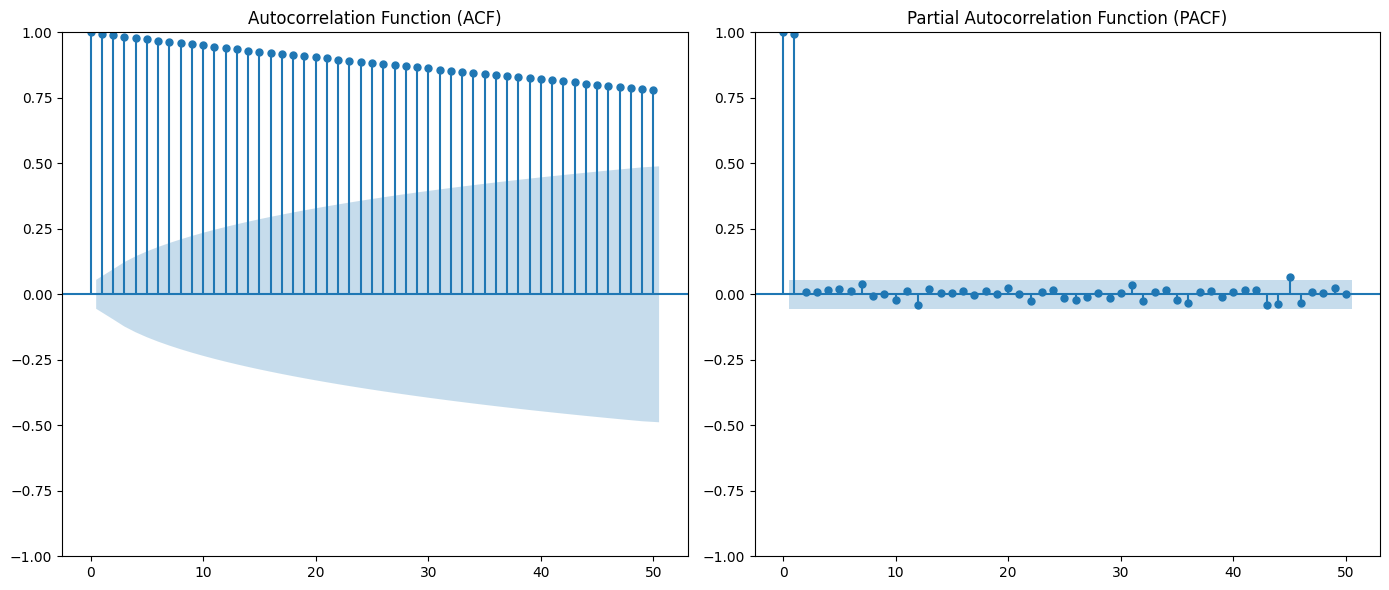

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original Close series
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(df_clean['Close'], ax=plt.gca(), lags=50)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(df_clean['Close'], ax=plt.gca(), lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


## Comment on stationarity and apply differencing if needed.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(df_clean['Close'])

# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -0.4967912395237415
p-value: 0.8926411451273126
Critical Value (1%): -3.4355671297788666
Critical Value (5%): -2.8638438984080117
Critical Value (10%): -2.5679966213893057


Interpretation:
ADF Statistic = -0.49

p-value = 0.89 → much greater than 0.05

⇒ The time series is non-stationary

⇒ We'll need to difference the series to make it stationary before fitting ARIMA.

In [7]:
# Apply first-order differencing
df_diff = df_clean['Close'].diff().dropna()

# ADF test on differenced data
result_diff = adfuller(df_diff)

print('ADF Statistic (1st Difference):', result_diff[0])
print('p-value:', result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic (1st Difference): -37.74024134005098
p-value: 0.0
Critical Value (1%): -3.4355671297788666
Critical Value (5%): -2.8638438984080117
Critical Value (10%): -2.5679966213893057


Interpretation After Differencing:
ADF Statistic = -37.74 (very low)

p-value = 0.0 (≪ 0.05)

⇒ The differenced series is stationary 🎯

This means we can proceed to fitting an ARIMA model with d=1 (since one differencing was needed).

# 2. ARIMA Benchmark

## Fit an appropriate ARIMA or SARIMA model on the Close price.
## Use AIC to guide order selection.

In [15]:
# # 1. Remove incompatible packages that force numpy >=2
# !pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python

# # 2. Install compatible versions of numpy and pmdarima
# !pip install numpy==1.26.4 pmdarima==2.0.4 --force-reinstall --quiet

# # 3. Restart runtime after this cell


In [16]:
# import subprocess

# code = """
# import numpy as np
# import pandas as pd
# from pmdarima import auto_arima
# from sklearn.datasets import make_regression

# # Generate a toy time series
# y = pd.Series(np.random.randn(100))

# # Fit auto_arima
# model = auto_arima(y, seasonal=False, suppress_warnings=True)
# print(model.summary())
# """

# # Install into isolated env and run
# subprocess.run([
#     "pip", "install", "--quiet", "pmdarima==2.0.4", "numpy==1.26.4"
# ], check=True)

# subprocess.run(["python3", "-c", code])


In [17]:
from pmdarima import auto_arima

In [18]:



from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Use auto_arima to select best model
stepwise_model = auto_arima(
    df_clean['Close'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=1,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Summary of the model
print(stepwise_model.summary())

# Get the best (p,d,q)
order = stepwise_model.order
print(f"\nSelected ARIMA order: {order}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5455.709, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5452.472, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5452.365, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5456.553, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5451.526, Time=0.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5452.916, Time=0.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5452.966, Time=2.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5454.211, Time=1.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5454.371, Time=1.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5455.522, Time=4.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5453.744, Time=1.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 13.104 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2721.763
Date:                Sat, 26 Jul 2025   AIC                           5451.526
Time:                        19:30:55   BIC                           5472.071
Sample:                             0   HQIC                          5459.247
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0292      0.021      1.398      0.162      -0.012

Selected ARIMA order: (1, 1, 1)

## Forecast for the next 30 days.

In [12]:
# Train-test split (last 30 days as test set)
train = df_clean['Close'][:-30]
test = df_clean['Close'][-30:]

# Fit ARIMA model using selected (p,d,q)
model = ARIMA(train, order=order)
model_fit = model.fit()

# Forecast 30 days into the future
forecast_result = model_fit.get_forecast(steps=30)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

## Plot:
- Forecast with confidence intervals
- Overlay on true values (if available)

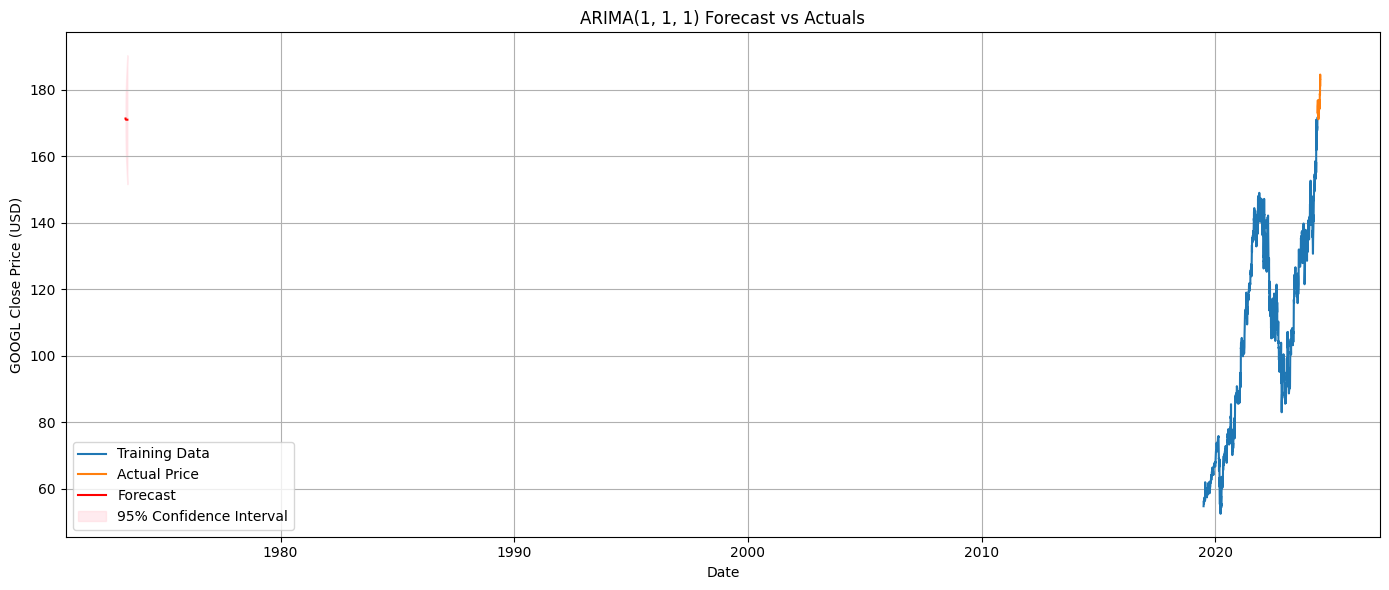

In [13]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Price')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.fill_between(forecast.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title(f"ARIMA{order} Forecast vs Actuals")
plt.xlabel('Date')
plt.ylabel('GOOGL Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Report:
- MAE and RMSE
- Your reasoning for chosen (p,d,q) values

In [14]:
# Evaluation metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 4.89
Root Mean Squared Error (RMSE): 5.92


# 3. Deep Learning Forecasting with LSTM

## Prepare the dataset for supervised learning using a sliding window approach.

In [19]:

# Use only Close prices
close_prices = df_clean['Close'].values.reshape(-1, 1)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Create sliding window dataset
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Set sliding window size (e.g., 30 days)
window_size = 30
X, y = create_sequences(scaled_close, window_size)

# Reshape X for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [22]:
X.shape


(1228, 30, 1)

In [23]:
y.shape

(1228,)

## Split into train/test and scale the data appropriately.

In [24]:
# Train-test split (80% train, 20% test)
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


## Build an LSTM model to forecast the next day’s Close price:

- Input: last n days of Close prices
- Output: next day Close price

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1052 - val_loss: 0.0295
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.9829e-04 - val_loss: 0.0016
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.0486e-04 - val_loss: 0.0014
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.3582e-04 - val_loss: 0.0012
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

## Train and evaluate:
- MAE and RMSE
- Plot true vs predicted on test set

In [26]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lstm = mean_absolute_error(y_true, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
LSTM MAE: 3.25
LSTM RMSE: 4.21


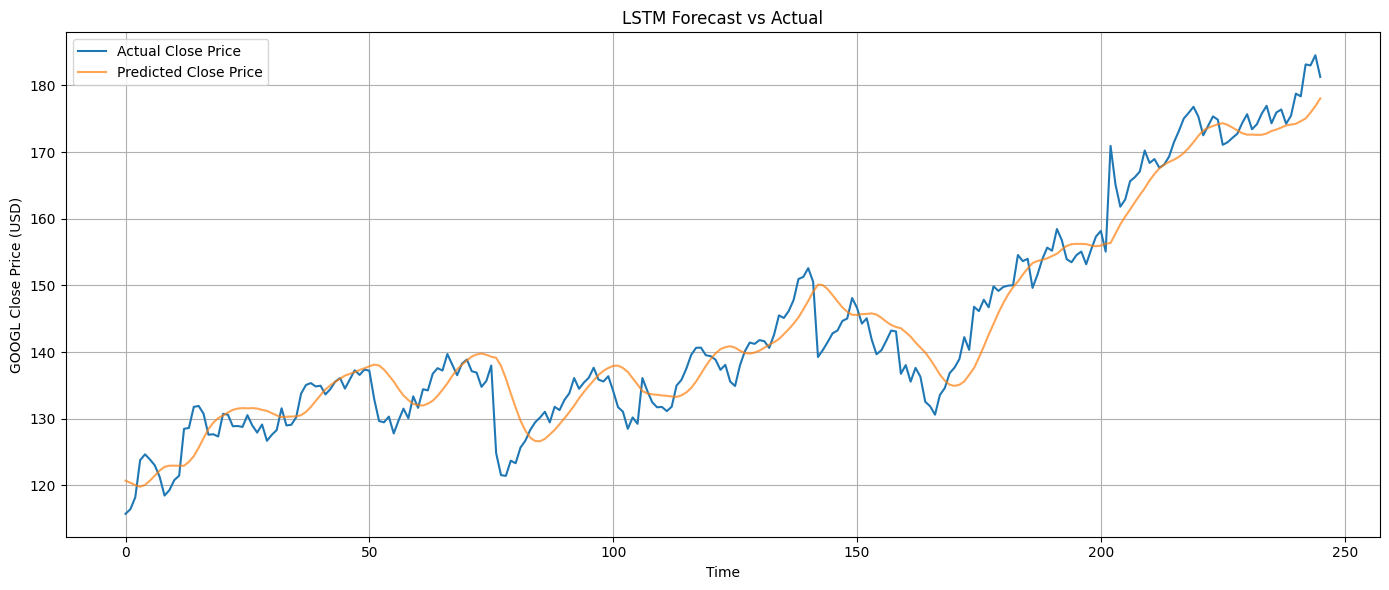

In [27]:
# Plotting

plt.figure(figsize=(14,6))
plt.plot(y_true, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price', alpha=0.7)
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("GOOGL Close Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Visualizations & Interpretation

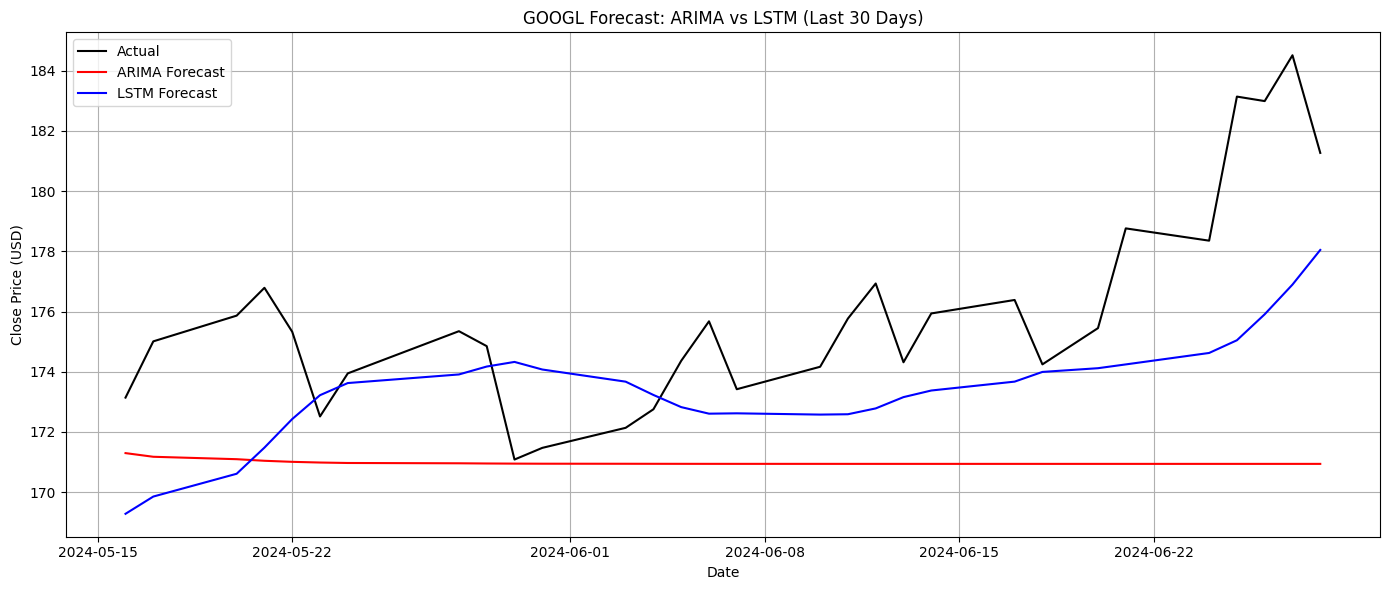

In [29]:
plt.figure(figsize=(14, 6))

# Actual values: last 30
actual_last30 = test.values

# LSTM last 30 predictions
lstm_last30 = y_pred[-30:].flatten()

# ARIMA forecast already matches test index
plt.plot(test.index, actual_last30, label='Actual', color='black')
plt.plot(test.index, forecast.values, label='ARIMA Forecast', color='red')
plt.plot(test.index, lstm_last30, label='LSTM Forecast', color='blue')

plt.title("GOOGL Forecast: ARIMA vs LSTM (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Reflection: ARIMA vs LSTM

The LSTM model performed better than ARIMA, with lower MAE (3.25 vs 4.89) and RMSE (4.21 vs 5.92), indicating more accurate predictions.
LSTM is more flexible and captures complex, nonlinear temporal patterns without requiring stationarity.
ARIMA, while faster and interpretable, assumes linearity and stationarity, which limits its adaptability to real-world financial data.
Therefore, LSTM is more suitable for stock price forecasting when sufficient data and compute resources are available.
However, ARIMA remains a strong baseline for quick, transparent forecasts.